## Movie Recommendation System using Apriori Algorithm in Python

Goal: Explore the Apriori algorithm, a data mining technique commonly used in Market Basket Analysis, to build a movie recommendation engine.

Context

Apriori algorithm works on the principle of Association Rule Mining. This technique is used to identify underlying relations between different items; in this case, movies. 

The data is obtained from MovieLens’s website(http://grouplens.org/datasets/movielens/). The model is trained on MovieLens 'ml-latest-small' dataset which consisted of 20,000,263 user ratings, across 100836 movies and 610 raters. 

### EDA

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

From the ml-latest-small directory, consider the 2 data files:

- movies.csv(contains information about movies)
- ratings.csv(user ratings)

In [118]:
movies = pd.read_csv('ml-latest-small/movies.csv')

In [119]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [120]:
movies.info() #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [121]:
# extract the year from the title
def extract_year(title):
    year = title.split('(')[-1].split(')')[0].split('-')[0]
    return year if year.isdigit() else np.nan

In [122]:
# Apply the function to the 'title' column and create the 'year' column
movies['year'] = movies['title'].apply(extract_year)

In [123]:
# Drop the year from the title to keep only the movie name
movies['title'] = movies['title'].str.replace(r"\s*\(\d{4}\)$", "", regex=True)

In [124]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [125]:
movies.isnull().sum()

movieId     0
title       0
genres      0
year       13
dtype: int64

In [126]:
# Display movies where the 'year' is NaN
discarded_movies = movies[movies['year'].isna()]

In [127]:
discarded_movies

,movieId,title,genres,year
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


- 13 movies have no release year/invalid title format. 
- For this analysis such movies can be discarded

In [128]:
movies = movies.drop(discarded_movies.index)

In [129]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9729 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9729 non-null   int64 
 1   title    9729 non-null   object
 2   genres   9729 non-null   object
 3   year     9729 non-null   object
dtypes: int64(1), object(3)
memory usage: 380.0+ KB


In [130]:
# Split genres using the '|' separator and create a list of genres
genres_list = movies['genres'].str.split('|').tolist()

In [131]:
#extract genres for each movie
genres_list

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Adventure', 'Children', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy'],
 ['Action', 'Crime', 'Thriller'],
 ['Comedy', 'Romance'],
 ['Adventure', 'Children'],
 ['Action'],
 ['Action', 'Adventure', 'Thriller'],
 ['Comedy', 'Drama', 'Romance'],
 ['Comedy', 'Horror'],
 ['Adventure', 'Animation', 'Children'],
 ['Drama'],
 ['Action', 'Adventure', 'Romance'],
 ['Crime', 'Drama'],
 ['Drama', 'Romance'],
 ['Comedy'],
 ['Comedy'],
 ['Action', 'Comedy', 'Crime', 'Drama', 'Thriller'],
 ['Comedy', 'Crime', 'Thriller'],
 ['Crime', 'Drama', 'Horror', 'Mystery', 'Thriller'],
 ['Action', 'Crime', 'Thriller'],
 ['Drama', 'Sci-Fi'],
 ['Drama', 'Romance'],
 ['Drama'],
 ['Children', 'Drama'],
 ['Drama', 'Romance'],
 ['Adventure', 'Drama', 'Fantasy', 'Mystery', 'Sci-Fi'],
 ['Crime', 'Drama'],
 ['Drama'],
 ['Mystery', 'Sci-Fi', 'Thriller'],
 ['Children', 'Drama'],
 ['Crime', 'Drama'],
 ['Children', 'Comedy'],
 

In [146]:
# Unlist the nested list of genres to get a flat list
# Unique genresmovoes
unique_genres = np.unique([genre for sublist in genres_list for genre in sublist])

In [147]:
unique_genres

array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'], dtype='<U18')

In [148]:
movies[movies['genres'] == '(no genres listed)']

,movieId,title,genres,year
8517,114335,La cravate,(no genres listed),1957
8684,122888,Ben-hur,(no genres listed),2016
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tales,(no genres listed),2017
8782,129250,Superfast!,(no genres listed),2015
8836,132084,Let It Be Me,(no genres listed),1995
8902,134861,Trevor Noah: African American,(no genres listed),2013
9033,141131,Guardians,(no genres listed),2016
9053,141866,Green Room,(no genres listed),2015
9070,142456,The Brand New Testament,(no genres listed),2015
9178,149330,A Cosmic Christmas,(no genres listed),1977


In [151]:
# One hot encoding
# Iterate through each genre and create a new column with 1 if the genre is present and 0 otherwise
for genre in unique_genres:
    movies.loc[:, f'genre_{genre}'] = (movies['genres'].str.contains(genre)).astype(int)


C:\Users\DELL\AppData\Local\Temp\ipykernel_19500\3226574040.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movies.loc[:, f'genre_{genre}'] = ((movies['genres'].str.contains(genre)) | (movies['genres'].str.contains("no genres"))).astype(int)


In [152]:
movies.head()

,movieId,title,genres,year,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children|Fantasy,1995,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [153]:
movies.columns

Index(['movieId', 'title', 'genres', 'year', 'genre_(no genres listed)',
       'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Children',
       'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
       'genre_Fantasy', 'genre_Film-Noir', 'genre_Horror', 'genre_IMAX',
       'genre_Musical', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi',
       'genre_Thriller', 'genre_War', 'genre_Western'],
      dtype='object')

In [154]:
#drop column genres
movies.drop('genres', axis=1, inplace = True)

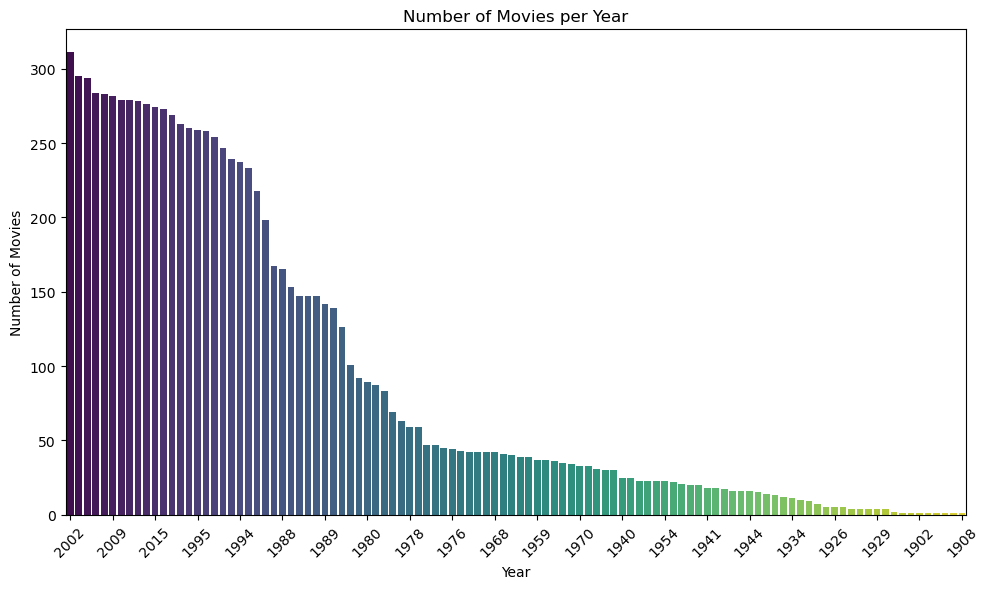

In [155]:
# Count the number of movies per year
movies_per_year = movies['year'].value_counts().reset_index()
movies_per_year.columns = ['year', 'count']

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='count', data=movies_per_year, palette='viridis')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Year')

# Set a step size to show every nth x-label
step_size = 5
plt.xticks(range(0, len(movies_per_year['year']), step_size), movies_per_year['year'][::step_size], rotation=45)

plt.tight_layout()
plt.show()

The entertainment industry is ever increasing due to economic development and the demand for leisure. Thus is must cater to the preferences of its consumers.

In [156]:
movies.columns

Index(['movieId', 'title', 'year', 'genre_(no genres listed)', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Children', 'genre_Comedy',
       'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Fantasy',
       'genre_Film-Noir', 'genre_Horror', 'genre_IMAX', 'genre_Musical',
       'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller',
       'genre_War', 'genre_Western'],
      dtype='object')

In [157]:
# Calculate the sum of each genre
genre_dist = movies.iloc[:, 3:].sum().sort_values()
genre_dist

genre_(no genres listed)      25
genre_Film-Noir              112
genre_IMAX                   183
genre_Western                192
genre_Musical                359
genre_War                    407
genre_Documentary            465
genre_Mystery                598
genre_Animation              636
genre_Children               689
genre_Fantasy                804
genre_Horror                1003
genre_Sci-Fi                1003
genre_Crime                 1224
genre_Adventure             1288
genre_Romance               1621
genre_Action                1852
genre_Thriller              1917
genre_Comedy                3781
genre_Drama                 4384
dtype: int64

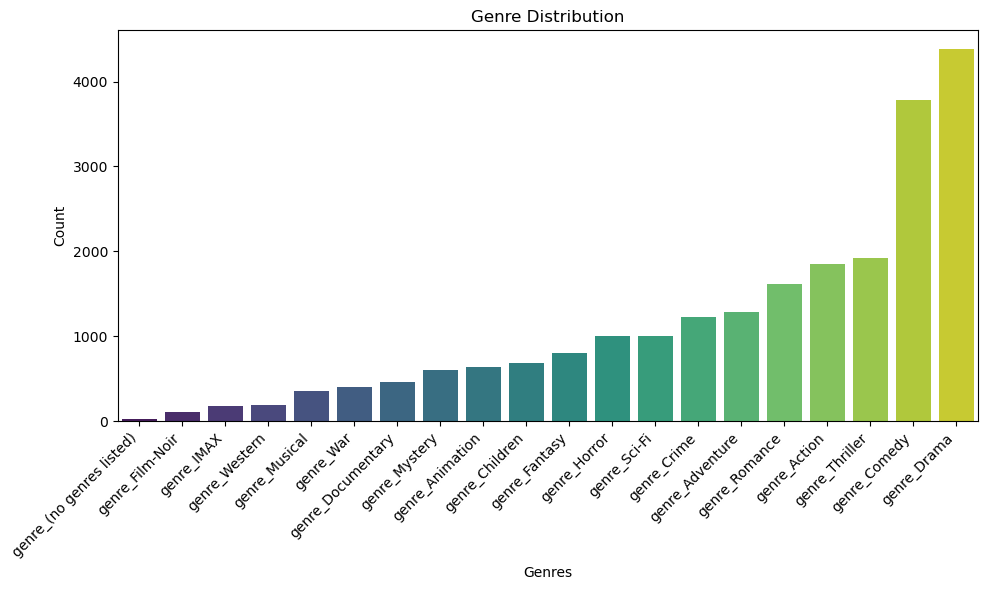

In [158]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_dist.index, y=genre_dist.values, palette='viridis')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Distribution')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [159]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [160]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


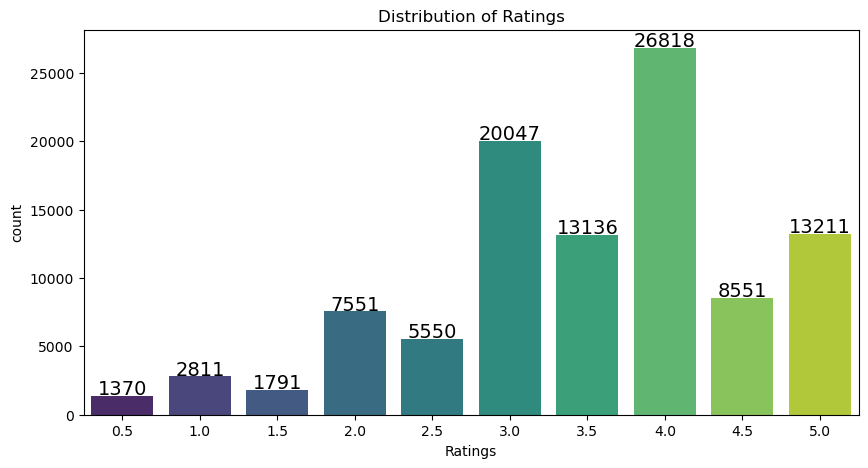

In [161]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=ratings, x='rating', palette='viridis')

labels = (ratings['rating'].value_counts().sort_index())
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')

for i,v in enumerate(labels):
    ax.text(i, v+100, str(v), horizontalalignment='center', size=14, color='black')
plt.show()

There are relatively fewer movies that are lower rated.

In [162]:
ratings.drop(ratings[['rating', 'timestamp']], axis = 1, inplace = True)

In [163]:
ratings

,userId,movieId
0,1,1
1,1,3
2,1,6
3,1,47
4,1,50
...,...,...
100831,610,166534
100832,610,168248
100833,610,168250
100834,610,168252


In [164]:
#discard ratings that contain id in discard_movie_id
ratings = ratings.drop(discarded_movies.index)

In [165]:
ratings.shape

(100823, 2)

In [166]:
top10 = ratings['movieId'].value_counts().sort_values(ascending=False)[:10]
top10

356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
Name: movieId, dtype: int64

In [167]:
# top 10 most watched movies
for i in top10.index:
    print(movies[movies['movieId'] == i]['title'])

314    Forrest Gump
Name: title, dtype: object
277    Shawshank Redemption, The
Name: title, dtype: object
257    Pulp Fiction
Name: title, dtype: object
510    Silence of the Lambs, The
Name: title, dtype: object
1939    Matrix, The
Name: title, dtype: object
224    Star Wars: Episode IV - A New Hope
Name: title, dtype: object
418    Jurassic Park
Name: title, dtype: object
97    Braveheart
Name: title, dtype: object
507    Terminator 2: Judgment Day
Name: title, dtype: object
461    Schindler's List
Name: title, dtype: object


In [168]:
ratings.columns

Index(['userId', 'movieId'], dtype='object')

In [169]:
# Merge Tables
movie_names = movies[['movieId', 'title']]
combined_movies = pd.merge(ratings, movie_names, on='movieId')
combined_movies = combined_movies[['userId','title']]
combined_movies.head()

,userId,title
0,1,Toy Story
1,5,Toy Story
2,7,Toy Story
3,15,Toy Story
4,17,Toy Story


In [52]:
combined_movies.title.unique()

array(['Toy Story', 'Grumpier Old Men', 'Heat', ..., 'Hazard',
       'Blair Witch', '31'], dtype=object)

In [171]:
Table = combined_movies.pivot_table(index='userId', columns='title', aggfunc=len, fill_value=0)
Table = Table.fillna(0)
Table[Table>1]=1
Table.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,(500) Days of Summer,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
Table.shape #610 users; 9433 movies

(610, 9433)

## Apriori Algorithm

Apriori algorithm uses frequent itemset to generate association rules.      
It is based on the concept that a subset of a frequent itemset must also be a frequent itemset.

There are three major components of the Apriori algorithm:
1) Support
- It is the frequency of item A or combination of item A and B. 
- It refers to the popularity of the item
- Support(A) = freq(A)/N; N is total transactions  
- Support(A -> B) = freq(A, B)/N; N is total transactions  
2) Confidence
- Likelihood that an item B is also bought if item A is bought.
- Confidence(A -> B) = freq(A,B) / freq(A) or 
- Confidence(A -> B) = Support(A -> B)/Support(A)
3) Lift
- Represents the strength of the rule 
- Lift refers to the increase in the ratio of the sale of B when A is sold.
- Lift(A -> B)  = Confidence(A -> B)/Support (B) or 
- Lift(A -> B)  = Support(A -> B)/(Support(A)xSupport(B))

Association rule by Lift
- lift = 1: A and B are independent.
- lift < 1: negative relationship between A and B.
- lift > 1: positive relationship between A and B.

In [172]:
#!pip install mlxtend
from mlxtend.frequent_patterns import association_rules, apriori

# Convert all non-zero values to True and all zero values to False
onehot = onehot.astype(bool)

# Frequent itemset mining using Apriori
frequent_itemsets = apriori(onehot, min_support=0.15, max_len=2, use_colnames=True)

# Generate association rules
#Lift equal 1 suggests that the 2 items are independent. The higher the number, the more they related.
#rules with lift>1
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [173]:
frequent_itemsets

,support,itemsets
0,0.178689,(2001: A Space Odyssey)
1,0.263934,(Ace Ventura: Pet Detective)
2,0.300000,(Aladdin)
3,0.239344,(Alien)
4,0.206557,(Aliens)
...,...,...
1117,0.185246,"(Terminator 2: Judgment Day, Twelve Monkeys (a..."
1118,0.178689,"(Terminator 2: Judgment Day, Usual Suspects, The)"
1119,0.170492,"(Toy Story, Twelve Monkeys (a.k.a. 12 Monkeys))"
1120,0.157377,"(Toy Story, Usual Suspects, The)"


In [174]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Aladdin),(Ace Ventura: Pet Detective),0.300000,0.263934,0.175410,0.584699,2.215321,0.096230,1.772368,0.783712
1,(Ace Ventura: Pet Detective),(Aladdin),0.263934,0.300000,0.175410,0.664596,2.215321,0.096230,2.087037,0.745311
2,(Ace Ventura: Pet Detective),(Apollo 13),0.263934,0.329508,0.177049,0.670807,2.035784,0.090081,2.036777,0.691227
3,(Apollo 13),(Ace Ventura: Pet Detective),0.329508,0.263934,0.177049,0.537313,2.035784,0.090081,1.590851,0.758829
4,(Ace Ventura: Pet Detective),(Batman),0.263934,0.309836,0.175410,0.664596,2.144993,0.093633,2.057711,0.725205
...,...,...,...,...,...,...,...,...,...,...
1913,(Twelve Monkeys (a.k.a. 12 Monkeys)),(Toy Story),0.290164,0.352459,0.170492,0.587571,1.667061,0.068221,1.570065,0.563710
1914,(Toy Story),"(Usual Suspects, The)",0.352459,0.334426,0.157377,0.446512,1.335157,0.039506,1.202507,0.387658
1915,"(Usual Suspects, The)",(Toy Story),0.334426,0.352459,0.157377,0.470588,1.335157,0.039506,1.223133,0.377155
1916,(Twelve Monkeys (a.k.a. 12 Monkeys)),"(Usual Suspects, The)",0.290164,0.334426,0.163934,0.564972,1.689376,0.066896,1.529955,0.574873


In [175]:
#sort the result by descending order of lift. So that the most likely movie that the user will watch is recommended first.
rules.sort_values(by = 'lift' ,ascending = False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1245,(Kill Bill: Vol. 1),(Kill Bill: Vol. 2),0.214754,0.180328,0.168852,0.786260,4.360167,0.130126,3.834895,0.981414
1244,(Kill Bill: Vol. 2),(Kill Bill: Vol. 1),0.180328,0.214754,0.168852,0.936364,4.360167,0.130126,12.339578,0.940194
86,(Alien),(Aliens),0.239344,0.206557,0.170492,0.712329,3.448576,0.121053,2.758158,0.933438
87,(Aliens),(Alien),0.206557,0.239344,0.170492,0.825397,3.448576,0.121053,4.356483,0.894866
746,"(Incredibles, The)",(Finding Nemo),0.204918,0.231148,0.162295,0.792000,3.426383,0.114929,3.696406,0.890659
747,(Finding Nemo),"(Incredibles, The)",0.231148,0.204918,0.162295,0.702128,3.426383,0.114929,2.669204,0.921044
1107,(Pirates of the Caribbean: The Curse of the Bl...,"(Incredibles, The)",0.244262,0.204918,0.155738,0.637584,3.111409,0.105684,2.193837,0.897934
1106,"(Incredibles, The)",(Pirates of the Caribbean: The Curse of the Bl...,0.204918,0.244262,0.155738,0.760000,3.111409,0.105684,3.148907,0.853500
534,"(Dark Knight, The)",(Inception),0.244262,0.234426,0.177049,0.724832,3.091942,0.119788,2.782207,0.895256
535,(Inception),"(Dark Knight, The)",0.234426,0.244262,0.177049,0.755245,3.091942,0.119788,3.087728,0.883754


The lift of 4.36 implies that there is 4.36 times more chance of watching 'Kill Bill: Vol. 2' and 'Kill Bill: Vol. 1' together then just watching 'Kill Bill: Vol. 1' alone.

In [176]:
#Lift equal 1 suggests that A and B are independent. The higher the number, the more they related.
#rules with confidence>70% and lift>1
rules[(rules['confidence']>0.7)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
6,(Batman Forever),(Ace Ventura: Pet Detective),0.224590,0.263934,0.157377,0.700730,2.654939,0.098100,2.459536,0.803889
15,(Dumb & Dumber (Dumb and Dumber)),(Ace Ventura: Pet Detective),0.218033,0.263934,0.165574,0.759398,2.877224,0.108027,3.059273,0.834361
17,(Ace Ventura: Pet Detective),(Forrest Gump),0.263934,0.539344,0.208197,0.788820,1.462554,0.065845,2.181340,0.429669
20,(Ace Ventura: Pet Detective),(Jurassic Park),0.263934,0.390164,0.190164,0.720497,1.846652,0.087186,2.181858,0.622878
27,(Ace Ventura: Pet Detective),(Pulp Fiction),0.263934,0.503279,0.203279,0.770186,1.530338,0.070446,2.161409,0.470813
...,...,...,...,...,...,...,...,...,...,...
1884,(X-Men),(Star Wars: Episode V - The Empire Strikes Back),0.218033,0.345902,0.159016,0.729323,2.108470,0.083598,2.416530,0.672308
1889,"(Terminator, The)",(Star Wars: Episode VI - Return of the Jedi),0.214754,0.321311,0.168852,0.786260,2.447032,0.099850,3.175293,0.753066
1896,(X-Men),(Star Wars: Episode VI - Return of the Jedi),0.218033,0.321311,0.159016,0.729323,2.269833,0.088960,2.507377,0.715425
1900,(Stargate),(True Lies),0.229508,0.291803,0.177049,0.771429,2.643660,0.110078,3.098361,0.806935


In [177]:
#Let's see what the model recommends to someone who has watched Spider-Man.
x = rules[rules['antecedents'].apply(lambda x: len(x) ==1 and next(iter(x)) == 'Spider-Man')]
#x = x[x['lift'] > 2]
x.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
866,(Spider-Man),(Forrest Gump),0.2,0.539344,0.154098,0.770492,1.428571,0.046230,2.007143,0.375000
1317,(Spider-Man),(Lord of the Rings: The Fellowship of the Ring...,0.2,0.324590,0.163934,0.819672,2.525253,0.099016,3.745455,0.755000
1356,(Spider-Man),"(Lord of the Rings: The Return of the King, The)",0.2,0.303279,0.152459,0.762295,2.513514,0.091803,2.931034,0.752688
1392,(Spider-Man),"(Lord of the Rings: The Two Towers, The)",0.2,0.308197,0.159016,0.795082,2.579787,0.097377,3.376000,0.765464
1472,(Spider-Man),"(Matrix, The)",0.2,0.455738,0.168852,0.844262,1.852518,0.077705,3.494737,0.575243


In [178]:
list = x['consequents'].values

# get unique movies in the order of descending lift.
movie_list = []
for movie in list:
    for title in movie:
        if title not in movie_list:
            movie_list.append(title)

In [179]:
#top 10 movies that the user is most likely to watch.
movie_list[0:10]

['Forrest Gump',
 'Lord of the Rings: The Fellowship of the Ring, The',
 'Lord of the Rings: The Return of the King, The',
 'Lord of the Rings: The Two Towers, The',
 'Matrix, The',
 'Star Wars: Episode IV - A New Hope']

Given a larger dataset the the relevance of the model would increase

Different approache:

- Build recommendation system using Recommendation Filtering techniques like Collaborative Filtering and Content-based Filtering.